# Citrination t-SNE API

In this tutorial, we're going to learn to use Citrination to generate a useful data analysis called t-SNE. This data visualization technique enables you to represent a high dimensional set of data in fewer dimensions in a way that preserves the local structure of the data. In materials informatics, this allows you to create a two-dimensional plot of a set of materials where points corresponding to similar materials are grouped together in two-dimensional space. More information on t-SNE here: https://lvdmaaten.github.io/tsne/

This tutorial will teach you to create and export a two-dimensional t-SNE plot for any data on Citrination. The first step is to create a data view on the Citrination: https://citrination.com/data_views. Instructions for creating a data view can be found in [this tutorial](https://github.com/CitrineInformatics/learn-citrination/blob/master/Journal%20Paper%20to%20Model%20Demo.ipynb).

We'll be using this data view: https://citrination.com/data_views/787 (view id 787) for this tutorial, which includes a model predicting experimental band gaps based on data compiled by W.H. Strehlow and E.L. Cook, which can be viewed in [this dataset](https://citrination.com/datasets/1160/show_search).

In [1]:
from citrination_client import CitrinationClient
import matplotlib.pyplot as plt
import os
import numpy as np

In [11]:
client = CitrinationClient(api_key=os.environ["CITRINATION_API_KEY"])

tsne_dataviewid = "4106"
tsne = client.models.tsne(tsne_dataviewid)
print(tsne.projections())

dict_keys(['Property Band gap', 'Property Color'])


The `tsne` call returns a dictionary where the top level keys correspond to the properties that are being modeled. In this data view, the model inputs are Chemical formula and Crystallinity. Citrine represents a chemical formula by calculating over 50 material descriptors. The t-SNE plot reduces that into just 2 dimensions. Let's look at the t-SNE plot for Band gap.

In [33]:
print(tsne.get_projection("Property Band gap"))

- `x` is the x component of the t-SNE plot
- `y` is the y component of the t-SNE plot
- `z` is the property value (Band gap in this example)
- `uid` is the uid of the record on Citrination. You can find the record by going to https://citrination.com/pif/{uid}
- `label` is the list of the values of the model inputs for the record

/Users/seto/anaconda2/envs/tensorflow36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


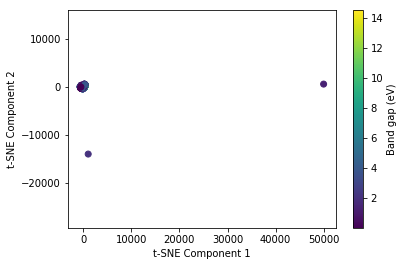

In [39]:
gap_projection = tsne.get_projection("Property Band gap")
plt.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(label="Band gap (eV)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.axes().set_aspect('equal', 'datalim')
# plt.xlim(-2500,2500)
# plt.ylim(-500,3500)
plt.show()

When interpreting a t-SNE plot, keep in mind that the t-SNE components plotted on the x and y axes have no physical meaning. Since the t-SNE algorithm preserves the local structure of the data, we look at points that end up close together. Just from looking at the plot, we can see that there is a cluster of high bandgap materials that contains the material with the maximum band gap in the bottom right corner. Let's take a look at what those materials are.


(note: t-SNE is a non-deterministic algorithm, so the plot will change if the underlying Data View is retrained)

In [40]:
# Load the coordinates and band gap values into a numpy array
coordinates_and_bg = np.zeros((len(gap_projection.xs), 3))
coordinates_and_bg[:,0] = gap_projection.xs
coordinates_and_bg[:,1] = gap_projection.ys
coordinates_and_bg[:,2] = gap_projection.responses

In [49]:
# Find the n materials closest to the target material, as specified by index
# based on cartesian distance in the t-SNE coordinates
def find_most_similar_materials(index, coordinates, n_materials=10):
    distances = np.linalg.norm(coordinates_and_bg[:,0:2] - coordinates_and_bg[index,0:2], axis=1)
    return np.argsort(distances)[1:n_materials+1]

From inspecting this cluster of materials, we can see that the t-SNE plot has grouped highly ionic materials together, and that these materials have very high band gaps.

Maximum band gap material:
Be1O1, Band gap: 14.5, URL: https://citrination.com/pif/1160/3/66756141934A40C0096E45068CE9B071
Similar materials:
B2O3, Polycrystalline, Band gap: 4.9, URL: https://citrination.com/pif/1160/3/C98CE9CE4C27BA625CF3478677A2D0C5
V1O2, Single crystalline, Band gap: 0.65, URL: https://citrination.com/pif/1160/3/DA5FA80CB61BDD6A092075F6817E42FD
V2O3, Single crystalline, Band gap: 0.1, URL: https://citrination.com/pif/1160/3/E694087444A1F8F0BD04E8934EE1A5F7
Ti1O2, Single crystalline, Band gap: 3.05, URL: https://citrination.com/pif/1160/3/F734845B82D2DEE1CB882ECEB37AEEC6
V1O1, Band gap: 0.3, URL: https://citrination.com/pif/1160/3/13A857F2BEA1AF21C9495CA6BFEE37BF
V4O7, Single crystalline, Band gap: 0.8, URL: https://citrination.com/pif/1160/3/157376D5171A19965C6D6218C8B4F01E
V2O5, Single crystalline, Band gap: 2.54, URL: https://citrination.com/pif/1160/3/CA4ED13625FFF3FFD77AA0446116B87B
Mg1O1, Single crystalline, Band gap: 7.69, URL: https://citrination.com/pif/116

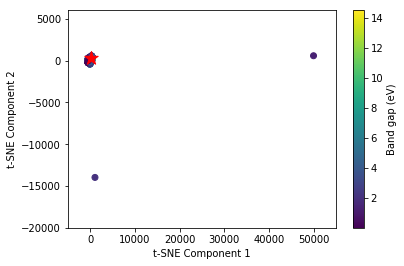

In [54]:
# Get the index of the maximum band gap material
max_bg_index = np.argmax(coordinates_and_bg, axis=0)[2]
print("Maximum band gap material:")
print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
      .format(gap_projection.tags[max_bg_index], 
              gap_projection.responses[max_bg_index],
              gap_projection.uids[max_bg_index])
     )
print("Similar materials:")
for idx in find_most_similar_materials(max_bg_index, coordinates_and_bg[:,0:2]):
    print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
          .format(gap_projection.tags[idx],
                  gap_projection.responses[idx],
                  gap_projection.uids[idx])
         )

plt.figure()
plt.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(label="Band gap (eV)")
plt.scatter(coordinates_and_bg[max_bg_index, 0], coordinates_and_bg[max_bg_index, 1],
            marker="*", c="r", s=200)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
#plt.axes().set_aspect('equal', 'datalim')
print(min(gap_projection.xs), max(gap_projection.xs), min(gap_projection.ys), max(gap_projection.ys))
plt.xlim(-5000,55000)
plt.ylim(-20000,6000)
plt.show()

Now let's figure out what material the outlier point with the largest y-value corresponds to

Outlier material (point with the highest y-value):
La2S3, Polycrystalline, Band gap: 1.32, URL: https://citrination.com/pif/1160/3/029F203BCD1C63011185C262945FD909
-651.6577729506878 49984.637839736446 -13976.535209245418 573.5589153283767


/Users/seto/anaconda2/envs/tensorflow36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


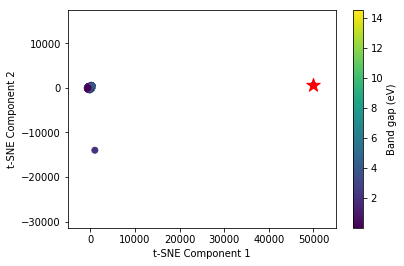

In [59]:
outlier_index = np.argmax(coordinates_and_bg, axis=0)[1]
print("Outlier material (point with the highest y-value):")
print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
      .format(gap_projection.tags[outlier_index],
              gap_projection.responses[outlier_index],
              gap_projection.uids[outlier_index])
     )

plt.figure()
plt.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(label="Band gap (eV)")
plt.scatter(coordinates_and_bg[outlier_index, 0], coordinates_and_bg[outlier_index, 1],
            marker="*", c="r", s=200)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
print(min(gap_projection.xs), max(gap_projection.xs), min(gap_projection.ys), max(gap_projection.ys))
plt.xlim(-5000,55000)
plt.ylim(-20000,6000)
plt.axes().set_aspect('equal', 'datalim')
plt.show()

We can also find materials that are similar to a given material in the dataset. Let's find materials similar to Cr3Se4 https://citrination.com/datasets/1160/version/3/pif/0478C7E0B7C4F75C6081EC5184522704. The uid comes in the format dataset_id/version/pif_id. For Cr3Se4, the uid is 1160/3/0478C7E0B7C4F75C6081EC5184522704.

Cr3Se4, Band gap: 0.015, URL: https://citrination.com/pif/1160/3/0478C7E0B7C4F75C6081EC5184522704
Similar materials:
Cr2Se3, Band gap: 0.15, URL: https://citrination.com/pif/1160/3/B02503AE0620DB98FC19B2637224AAEC
Mn1Se1, Single crystalline, Band gap: 1.8, URL: https://citrination.com/pif/1160/3/57C264FAE60E73465FA484FCC686CFD8
Ru1Se2, Polycrystalline, Band gap: 1.0, URL: https://citrination.com/pif/1160/3/EB7F89526BB12CD5DB57956267A4B814
Fe1Se2, Polycrystalline, Band gap: 0.5, URL: https://citrination.com/pif/1160/3/5FE698B58A042D23AA8B6EF0CB7C4923
Rh1Se3, Band gap: 0.7, URL: https://citrination.com/pif/1160/3/30EEC951791B144F58B004220982F02B
Rh1Se2, Band gap: 0.6, URL: https://citrination.com/pif/1160/3/53AE437CD930A984FD4C45C29F2F1B5F
Ru1P2, Polycrystalline, Band gap: 1.0, URL: https://citrination.com/pif/1160/3/532047FC884C8662B6F01D9759035CF6
Rh2S3, Band gap: 0.8, URL: https://citrination.com/pif/1160/3/5663B427D1ADBB8DBA1B8B503E394785
W1S2, Single crystalline, Band gap: 0.45, URL

/Users/seto/anaconda2/envs/tensorflow36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


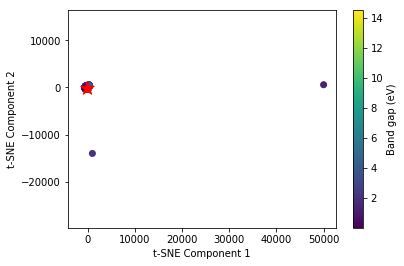

In [61]:
uid = "1160/3/0478C7E0B7C4F75C6081EC5184522704"
cr3se4_index = gap_projection.uids.index(uid)
print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
      .format(gap_projection.tags[cr3se4_index],
              gap_projection.responses[cr3se4_index],
              gap_projection.uids[cr3se4_index])
     )
print("Similar materials:")
for idx in find_most_similar_materials(cr3se4_index, coordinates_and_bg[:,0:2]):
    print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
          .format(gap_projection.tags[idx],
                  gap_projection.responses[idx],
                  gap_projection.uids[idx])
         )
plt.figure()
plt.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(label="Band gap (eV)")
plt.scatter(coordinates_and_bg[cr3se4_index, 0], coordinates_and_bg[cr3se4_index, 1],
            marker="*", c="r", s=200)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.axes().set_aspect('equal', 'datalim')
plt.show()

As we've seen here, t-SNE is a useful tool for understanding materials datasets and gaining new insights by visualizing and exploring a large, high-dimensional dataset in two dimensions. In this tutorial, we've seen how to examine outliers, find interesting clusters of similar materials, and find materials that are similar to a given material, which are only some of the cool things that you can do with t-SNE plots. The t-SNE analysis is available for all real-valued outputs specified in the Data Views creation process.